<a href="https://colab.research.google.com/github/zlatatikhomirova/emotion_recognition/blob/main/low_model_accuracy_ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

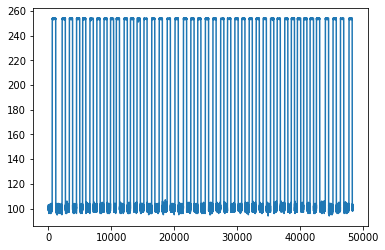

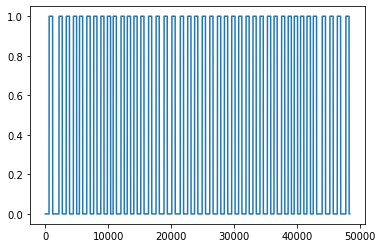

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


1 1 1 1 0 1 1 1 1 [0.4  0.6  0.5  0.5  0.5  0.5  0.5  0.75 0.75 0.75]
0.575


KeyboardInterrupt: ignored

In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from sklearn import preprocessing as ppc
from scipy import signal as sig
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

def func(data):
  ps = np.abs(np.fft.rfft(data))**2
  freqs = np.fft.rfftfreq(len(data), 1/240)
  idxs = np.where((8 <= freqs) & (freqs <= 13))[0]
  spectrum = sum(ps[idxs[0] :idxs[-1] + 1])
  return spectrum



data = np.loadtxt('eeg12.dat')
answers = open('answers.txt', 'r')

ans = eval(answers.read())
anss = [i for i in ans.values()]
emotions = [0 if i in range(1,5) else 1 for i in anss]

data = data[14000:62400]

ph_diode = np.transpose(data)[8]

plt.plot(range(len(ph_diode)), ph_diode)
plt.show()

ph_scaled = ppc.scale(ph_diode)
ph_clean = np.where( ph_scaled > 0, 1, 0)


plt.plot(range(len(ph_clean)), ph_clean)
plt.show()

starts = []
ends = []

for i in range(1, len(ph_clean)-1):
  if ph_clean[i-1] == 0 and ph_clean[i+1] == 1 and ph_clean[i] == 1:
    starts.append(i)

for i in range(1, len(ph_clean)-1):
  if ph_clean[i-1] == 1 and ph_clean[i+1] == 0 and ph_clean[i] == 1:
    ends.append(i)



data = np.transpose(np.array(data))

data_fltered = []

for i in [2,3]:
  data_fltered.append([])
  for j in range(len(starts)):
    data_fltered[-1].append(butter_bandpass_filter(data[i][starts[j] : ends[j]], 1.0, 20, 240))

data_fltered = np.array(data_fltered).T

answers = open('answers.txt', 'r')

sch2s = []
sch3s = []
for i in range(len(data_fltered)):
  sch2 = func(data_fltered[i][0][:490])
  sch3 = func(data_fltered[i][1][:490])
  sch2s.append(sch2)
  sch3s.append(sch3)

df = pd.DataFrame({'spectrum_ch2':sch2s, 'spectrum_ch3':sch3s, 'emotion':emotions[:42]})

y = df['emotion']
y= y.values
X = df.drop(['emotion'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
model = lr()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_1 = y_pred.tolist()

for i in y_pred_1:
  print(i, sep=' ', end=' ')
 
cross_val = cross_val_score(lr(), X, y, scoring='accuracy', cv=10)

print(cross_val)
print(cross_val.mean())